In [1]:
import os

import pandas as pd
import re

import numpy as np

import random

import Neuron_analysis as na

import plotly
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
results_dir= 'D:/Complete_points/'

In [3]:
files= os.listdir(results_dir)

## Plots all downsampled points into same space ##

In [4]:
axons=[os.path.join(results_dir,i) for i in files if '_axons.csv' in i]

In [5]:
data_pd=pd.read_csv(axons[0])
data_pd.loc[100:105]

IndexError: list index out of range

In [8]:
fig=go.Figure()

for count,names in enumerate(axons):
    data_pd=pd.read_csv(names)
    name= re.search('\D{2}[0-9]{3}', names)[0]
    
    data_pd['name']= [na.give_me_name(i) for i in data_pd['atlas_ID']]
    data_pd['ML']= [na.stereotaxis(i,ml=1) for i in data_pd['x']]
    data_pd['AP']= [na.stereotaxis(i,ml=0) for i in data_pd['z']]
    data_pd['DV']= [i*25/1000 for i in data_pd['y']]
    
    fig.add_trace(go.Scatter3d( 
        x=data_pd['ML'],
        y=data_pd['DV'],
        z=data_pd['AP'],
        
        mode='markers',
        name=name,
        marker=dict(
            size=1,
            color=count,
            opacity=0.5
        ),
        
        text=data_pd['name'],
        hovertemplate= '%{text}<br> ML: %{x} mm <br> AP: %{z} mm'
        
    ))

camera = dict(
        eye=dict(x=0, y=-1, z=0)
    )

    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Medial-lateral',
                        yaxis_title='Dorsal-ventral',
                        zaxis_title='Anterior-posterior'))
plot(fig,filename=results_dir+'allprojection3d.html')

'D:/Complete_points/allprojection3d.html'

## Plots the individual original points with associated ID ##

In [77]:
ori_points=[os.path.join(results_dir,i) for i in files if 'oripoints' in i]
ori_points

['D:/Complete_points/GF243D_oripoints_withID.csv',
 'D:/Complete_points/GF243_oripoints_withID.csv']

In [79]:
axons=pd.read_csv(ori_points[1])
#axons['name']= [na.give_me_name(i) for i in axons['atlasID']]
dendrites=pd.read_csv(ori_points[0])
#dendrites['name']= [na.give_me_name(i) for i in dendrites['atlasID']]
mousename=na.find_mousename(ori_points[1])

In [81]:
axons

,x,y,z,atlasID
0,5275.74,2194.85,3899.45,886
1,5275.51,2195.14,3898.52,886
2,5275.29,2195.44,3897.59,886
3,5275.06,2195.74,3896.66,886
4,5274.84,2196.03,3895.73,886
...,...,...,...,...
60055,5177.00,2768.27,4775.83,847
60056,5613.60,2982.40,4725.00,847
60057,5613.50,2982.40,4724.01,847
60058,5613.39,2982.40,4723.01,847


In [138]:
def make_scatter(axons, dendrites, mousename):
        
    fig=go.Figure()
    fig.add_trace(go.Scatter3d( 
        x=axons[::3]['x'],
        y=axons[::3]['y'],
        z=axons[::3]['z'],
        mode='markers',
        name='Axons',
        marker=dict(
            size=1,
            color='blue',
            opacity=0.5
        ),
        #hovertext= axons[::3]['name'],
        hovertext= axons['atlasID'],
        hoverinfo='text'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=dendrites['x'],
        y=dendrites['y'],
        z=dendrites['z'],
        mode='markers',
        name='Dendrites',
        marker=dict(
            size=2,
            color='red',
            opacity=0.5),
        #hovertext= dendrites['name'],
        hovertext=dendrites['atlasID'],
        hoverinfo='text'
    ))

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
    camera = dict(
            eye=dict(x=0, y=0, z=2.5))
    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
    fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Medial-lateral',
                        yaxis_title='Dorsal-ventral',
                        zaxis_title='Anterior-posterior'))
    #fig.write_image(f"D:/2PT electroporation time/{mousename}.svg")
    plot(fig,filename='D:/2PT electroporation time/'+ mousename+'/3Dplot.html')
    

In [139]:
make_scatter(axons,dendrites,mousename)

## Makes individual bar graph ##

In [4]:
files=[os.path.join('D:\\Complete_points\\' ,i) for i in files if 'region_with_counts' in i]

In [5]:
test= [i for i in files if re.search('AL140', i) ]
axon= test[0]
dendrite=test[1]
mousename=na.find_mousename(axon)

In [6]:
axon_bar=pd.read_excel(axon).sort_values(by=['Total_counts'])
dendrite_bar=pd.read_excel(dendrite).sort_values(by=['Total_counts'])

In [7]:
new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)

In [8]:
new_dendritepd= na.atlas_labels.merge(dendrite_bar, on= 'acronym')
new_dendritepd.sort_values(by= 'Total_counts',axis=0, inplace=True)

In [9]:
def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'Total_counts': grouped_pd.Total_counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['Total_counts'], ascending=True, inplace=True)
    # result is the final pd

    return result

### order by total amount of a parent region 

In [10]:
result= parent_df(new_axonpd)
new_order=result.id.to_numpy()
new_order

array([      402,      1011,       985,       485,       337,      1009,
             776, 182305689,       361, 312782546,       417,       378,
             369,       301,       329])

In [11]:
old_order= new_axonpd.parent_structure_id.to_numpy()   
old_order

array([9.85000000e+02, 9.85000000e+02, 3.29000000e+02, 3.29000000e+02,
       3.29000000e+02, 3.29000000e+02, 3.29000000e+02, 3.29000000e+02,
       3.37000000e+02, 3.37000000e+02, 3.69000000e+02, 3.69000000e+02,
       3.61000000e+02, 3.61000000e+02, 1.82305689e+08, 1.82305689e+08,
       3.78000000e+02, 3.78000000e+02, 3.78000000e+02, 1.01100000e+03,
       4.02000000e+02, 3.12782546e+08, 3.12782546e+08, 3.12782546e+08,
       4.17000000e+02, 4.17000000e+02, 4.17000000e+02, 4.85000000e+02,
       1.00900000e+03, 7.76000000e+02, 3.01000000e+02])

In [12]:
new_array= np.zeros_like(old_order)
for i, j in enumerate(new_order):
    new_array[old_order==j]=i

new_array
# generate new order for the detailed pd

array([ 2.,  2., 14., 14., 14., 14., 14., 14.,  4.,  4., 12., 12.,  8.,
        8.,  7.,  7., 11., 11., 11.,  1.,  0.,  9.,  9.,  9., 10., 10.,
       10.,  3.,  5.,  6., 13.])

In [13]:
new_axonpd['new_order']= new_array
new_axonpd.sort_values('new_order', inplace=True)

In [14]:
new_axonpd.sort_values(by=['new_order', 'region_id'], ascending=[True, False] ,inplace=True)
# sort by new order first (total amount within the same parent id), and then within each substructure, sort by layer 1 to layer 6

In [15]:
def plot_hist(pd_axon, pd_dendrite, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''
    y=pd_axon['acronym']
    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=1,
        row_heights=[0.9, 0.1],
        row_titles=['Axons', 'Dendrites']
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts']/1000, # units now in milimeters
        marker_color='red', #for future, pd_axon['region_id'],
        name='',
        text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    

    z=pd_dendrite['acronym']
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Total_counts']/1000, # units now in milimeters
        marker_color='black',
        name='',
        text=pd_dendrite['region_id'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )

    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      width=2000,
                      height=1000, # 1500 for AL066 since too many items
                      showlegend= False,
                      paper_bgcolor='rgba(0,0,0,0)', # transparent background
                      plot_bgcolor='rgba(0,0,0,0)' # transparent background
                     )
    
    fig.update_xaxes(gridcolor='gold')
    
    fig.show()
    # plotly.offline.plot(fig,filename='D:/'+ mousename+'/barplot.html')
    fig.write_image(f"{results_dir} {mousename}.svg")
    fig.write_html(f"{results_dir} {mousename}.html")

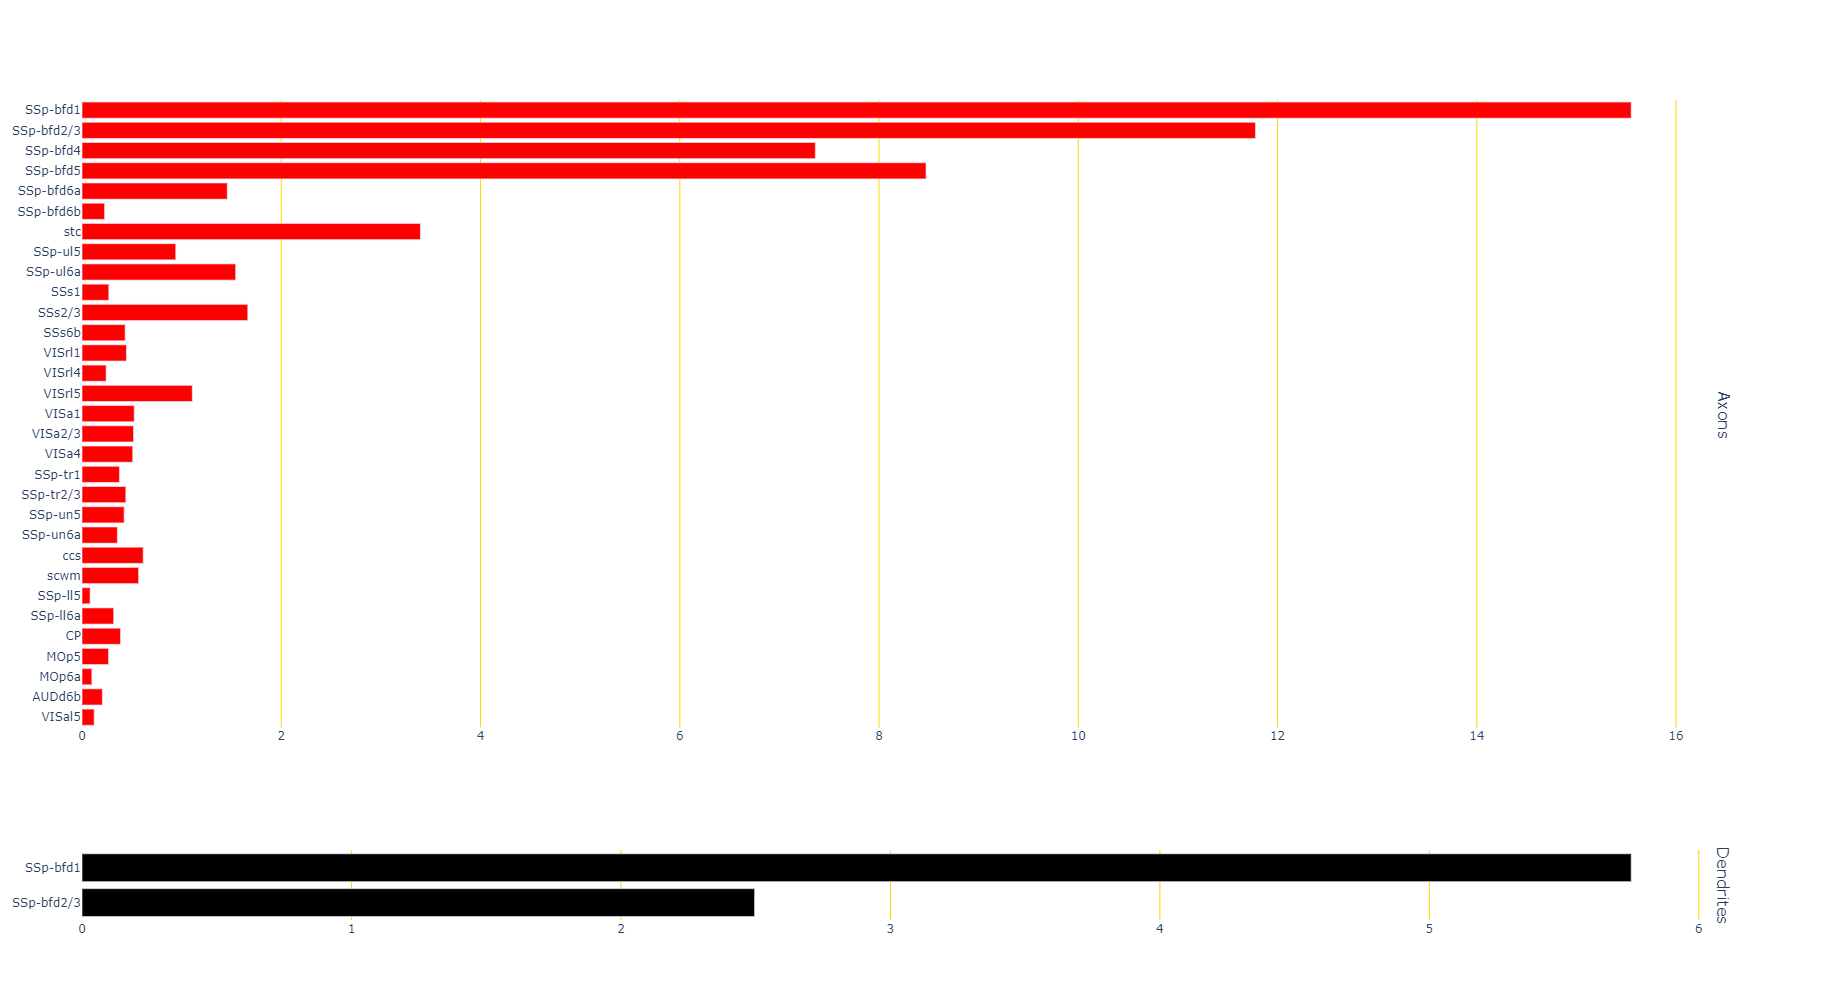

In [16]:
plot_hist(new_axonpd,new_dendritepd,mousename)

### create pd with parent structures (1 level up) for all

In [335]:
#plot_hist(result,new_dendritepd,mousename)

In [17]:
axon_files=[os.path.join('D:\\Complete_points\\' ,i) for i in files if 'axons_region_with_counts' in i]

In [18]:
all_mice= set([na.find_mousename(i) for i in files])
all_mice=list(all_mice)

In [19]:
out_dir= 'D:\\Complete_points\\'

In [20]:
for i in axon_files:
    axon_bar=pd.read_excel(i).sort_values(by=['Total_counts'])
    new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
    new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)
    mouse_name= na.find_mousename(i)
    result= parent_df(new_axonpd)
    result.to_excel(f'{out_dir}{mouse_name}_parent.xls')  
